In [113]:
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm
import warnings
from sklearn.metrics import pairwise_distances
warnings.filterwarnings('ignore')

Ниже реализация t-SNE

In [267]:
def compute_p(X, i, sigma):
    p = np.zeros(shape=(len(X),))
    denom = sum([np.exp(-norm(X[i] - X[k])**2/(2*sigma**2)) for k in range(len(X)) if k != i])
    for j in range(len(X)):
        p[j] = np.exp(-norm(X[i] - X[j])**2/(2*sigma**2))/denom
    return p


def compute_perp(p):
    H = -p@np.log2(p)
    return 2**H

def solve_bisect(f, l, r):
    fl = f(l)
    fr = f(r)
    if np.sign(fl) == np.sign(fr):
        if np.abs(fl) < np.abs(fr):
            return l
        else:
            return r
    for it in range(50):
        mid = (l + r)/2
        fm = f(mid)
        if np.sign(fm) != np.sign(fr):
            l = mid
        else:
            r = mid
        if np.abs(r-l) < 0.01:
            break
    return mid


def compute_sigma(X, i, perp):
    def f(sigma):
        p = compute_p(X, i, sigma)
        return perp - compute_perp(p)    
    return solve_bisect(f, 0.001, 1000)



def my_tSNE(X, iter_num=100, perp=40, lr=200, alpha=lambda t: 0.5):
    p = np.zeros(shape=(len(X), len(X)))
    sigma = np.array([1.0 for _ in range(len(X))])
    for i in tqdm(range(len(X)), leave=True, position=0):
        sigma[i] = compute_sigma(X, i, perp)
    
    for i in range(len(X)):
        p[i] = compute_p(X, i, sigma[i])
        
    p = (p + p.T) / (2*len(X))
    
    Y = np.random.normal(scale=0.0001, size=(len(X), 2))
    q = np.zeros(shape=(len(X), len(X)))
    diff = np.zeros(shape=(len(X), 2))
    
    for it in tqdm(range(iter_num), leave=True, position=0):
        denom = (1.0/(1.0 + pairwise_distances(Y)**2)).sum() - len(X)
        q = (1.0/(1 + pairwise_distances(Y)**2))/denom
                
        grad = np.zeros(shape=(len(X), 2))
        '''
        for i in range(len(X)):
            for j in range(len(X)):
                grad[i] += 4*(p[i][j] - q[i][j])*(Y[i] - Y[j])*(1 + norm(Y[i] - Y[j])**2)**-1
        '''
        for i in range(len(X)):
            tmp = (1 + ((Y[i] - Y)**2).sum(axis=1))**-1
            tmp = np.array([tmp, tmp]).T

            grad[i] = (4*(p[i] - q[i]) @ ((Y[i] - Y) * tmp))
                
        Y_new = Y - lr*grad + alpha(it)*diff
        diff = Y_new - Y
        Y = Y_new.copy()
    return Y

В качестве датасета возьмем MNIST. Возьмем 500 изображений и запустим t-SNE в 1000 итераций

In [81]:
from keras.datasets import mnist

In [268]:
data = mnist.load_data()

In [279]:
X = np.array([data[0][0][i].flatten() for i in range(0, 500)])
y = data[0][1][0:500]

In [280]:
X2d = my_tSNE(X, iter_num=1000, perp=30)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.16it/s]


И визуализируем что у нас получилось

In [281]:
from matplotlib import pyplot as plt
import seaborn as sns

<AxesSubplot:>

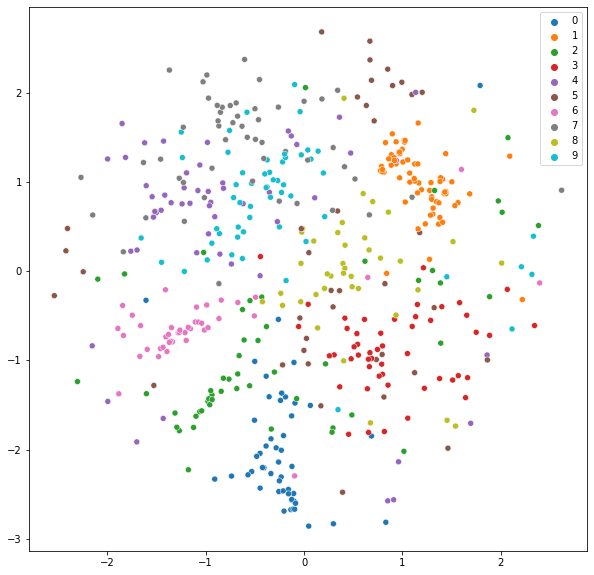

In [282]:
plt.figure(figsize=(10, 10))
sns.scatterplot(X2d[:,0], X2d[:,1], hue=y, palette=sns.color_palette("tab10"))

Есть некоторый разброс, но в целом видим что одинаковые цифры находятся рядом